# Short Chunk CNN 
This file traines a short chunk cnn from the melspectogram features


In [1]:
import numpy as np
import yaml
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
import pickle
from lib_util import utils, plot
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-01-14 15:26:21.854779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load in the preprocessed data

In [2]:
# Loading in the preprocessed melspectogram features data and the labels of the data
melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

print("Features:", melspec_data.shape)
print("Labels:", labels.shape)

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)
Features: (4068, 33152)
Labels: (4068, 5)


Split the data into train and test set

In [12]:
model_config = utils.get_config('shortchunkcnn')

train_size = model_config['train_size']
val_size = model_config['val_size']
#Split the data into train, validation and test 
mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=train_size, random_state=42)
mel_val, mel_test, lab_val, lab_test = train_test_split(mel_test_val, lab_test_val, test_size=(val_size/(1-train_size)), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]


Normalize the data 

In [4]:
def normalization(mel_train, mel_test, mel_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train_n, mel_test_n, mel_val_n = normalization(mel_train, mel_test, mel_val)

Reshape the melspec the models dimensions

In [5]:
n_mels = 128

def reshape_melspectogram(mel_train, mel_test, mel_val):
    """Reshaping the melspectogram features data 
    """
    n, m = mel_train.shape
    mel_train = mel_train.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_test.shape
    mel_test = mel_test.reshape((n, n_mels, int(m/n_mels), 1))
    n, m = mel_val.shape
    mel_val = mel_val.reshape((n, n_mels, int(m/n_mels), 1))
    return mel_train, mel_test, mel_val

mel_train_n, mel_test_n, mel_val_n = reshape_melspectogram(mel_train_n, mel_test_n, mel_val_n)

print(mel_train_n.shape)
print(mel_test_n.shape)
print(mel_val_n.shape)

(2440, 128, 259, 1)
(814, 128, 259, 1)
(814, 128, 259, 1)


Define the shot-chunk-cnn model

In [6]:
def shortchunckcnn(input_shape, output_shape):
    """ Short Chunck CNN model with different layers
    """
    model = Sequential()
    model.add(Conv2D(8, (3,3), activation= 'relu', input_shape=input_shape, padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
    model.add(MaxPooling2D((4,4), padding= 'same'))
    model.add(Flatten())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dense(output_shape, activation= 'softmax'))

    model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

model = shortchunckcnn(mel_train_n[0].shape, labels.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 259, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 65, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 65, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 17, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 17, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 5, 32)         0

2023-01-14 15:26:35.111873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 63,557
Trainable params: 63,557
Non-trainable params: 0
_________________________________________________________________


Train the defined model

In [7]:
callbacks = [
    ModelCheckpoint("models/short_chunk_cnn_{epoch:03d}.h5", save_freq=5),
    EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)
]

epochs=model_config['epochs']

history = model.fit(mel_train_n, lab_train, epochs=epochs, validation_data=(mel_val_n, lab_val), callbacks=callbacks, batch_size=32, verbose=1)

Epoch 1/100
77/77 [==============================] - 10s 108ms/step - loss: 1.4959 - accuracy: 0.3455 - val_loss: 1.2496 - val_accuracy: 0.5025
Epoch 2/100
77/77 [==============================] - 9s 113ms/step - loss: 1.1704 - accuracy: 0.5057 - val_loss: 1.1004 - val_accuracy: 0.5651
Epoch 3/100
77/77 [==============================] - 8s 98ms/step - loss: 1.0244 - accuracy: 0.5852 - val_loss: 1.2096 - val_accuracy: 0.5332
Epoch 4/100
77/77 [==============================] - 8s 109ms/step - loss: 0.9068 - accuracy: 0.6455 - val_loss: 0.8661 - val_accuracy: 0.6769
Epoch 5/100
77/77 [==============================] - 8s 106ms/step - loss: 0.8702 - accuracy: 0.6619 - val_loss: 0.9114 - val_accuracy: 0.6425
Epoch 6/100
77/77 [==============================] - 8s 103ms/step - loss: 0.8067 - accuracy: 0.6811 - val_loss: 0.7649 - val_accuracy: 0.7248
Epoch 7/100
77/77 [==============================] - 8s 103ms/step - loss: 0.6991 - accuracy: 0.7225 - val_loss: 0.7524 - val_accuracy: 0.7408

Save the history from training to file

In [8]:
to_dump = {
    'model': model,
    'history': history,
    'config': model_config
}

utils.save_training(to_dump, model_config['model_name'])

INFO:tensorflow:Assets written to: models/shortchunkcnn_trained/assets


INFO:tensorflow:Assets written to: models/shortchunkcnn_trained/assets


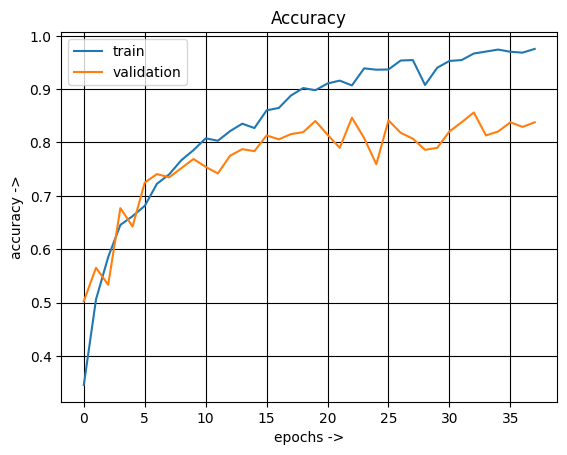

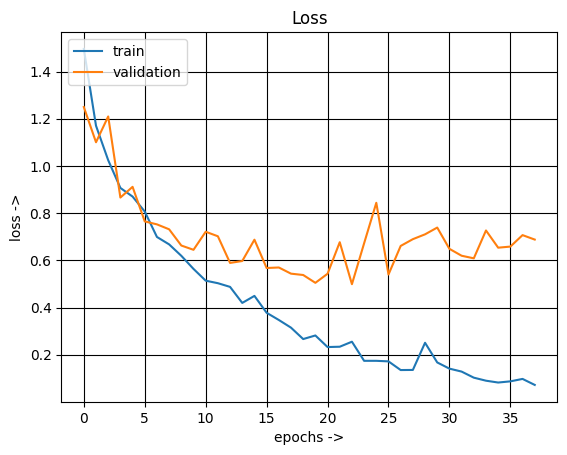

In [9]:
history_dict = utils.load_history(model_config['model_name'])

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history_dict, ('accuracy', 'val_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_acuracy')
plot.plot_hist(history_dict, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/short_chunk_cnn_{epochs}_loss')

Predictions for the three different sets

In [13]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

#Loading in the model
model = utils.load_model(model_config['model_name'])

# Training prediction
y_pred_train = predict(model, mel_train_n)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='weighted')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val_n)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_val, y_pred_val, average='weighted')*100:.4f} %")


# Test prediction
y_pred_test = predict(model, mel_test_n)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_test, y_pred_test, average='weighted')*100:.4f} %")

77/77 [==============================] - 3s 35ms/step
ACCURACY FOR TRAIN SET 95.2459 %
MACRO F1 SCORE FOR TRAIN SET 94.9015 %
MICRO F1 SCORE FOR TRAIN SET 95.2459 %
WEIGHTED F1 SCORE FOR TRAIN SET 95.2539 %
26/26 [==============================] - 1s 39ms/step
ACCURACY FOR VAL SET 84.6437 %
MACRO F1 SCORE FOR VAL SET 83.2157 %
MICRO F1 SCORE FOR VAL SET 84.6437 %
WEIGHTED F1 SCORE FOR TRAIN SET 84.5385 %
26/26 [==============================] - 1s 30ms/step
ACCURACY FOR TEST SET 81.5725 %
MACRO F1 SCORE FOR TEST SET 80.1701 %
MICRO F1 SCORE FOR TEST SET 81.5725 %
WEIGHTED F1 SCORE FOR TRAIN SET 81.4253 %


# Plot the confusion matrix on the test set
horizontal: predicted labels  
vertical: true labels

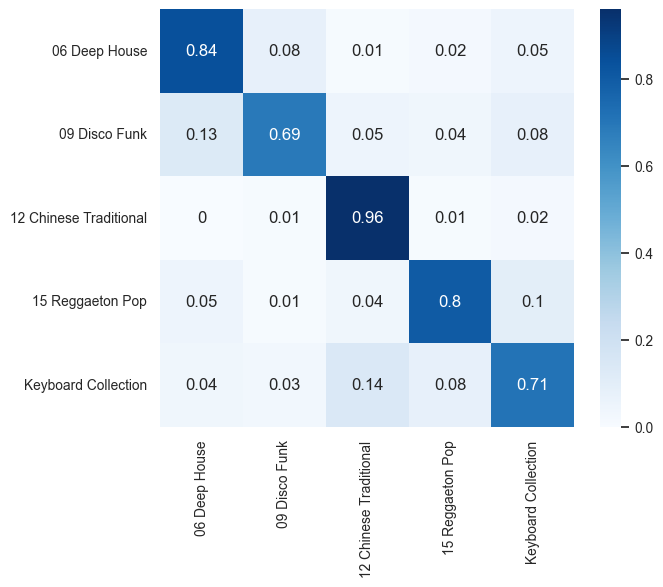

In [14]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/short_chunk_cnn_{epochs}_test_conf_mat.png")